In [1]:
import os
import numpy as np
import pymatgen as mg
import pandas as pd
from pymatgen.core import Structure
from figrecipes import PlotlyFig
import matplotlib.pyplot as plt
import seaborn as sns
from pymatgen.io.cif import CifWriter
from cbfv.composition import generate_features as gf
from sklearn.preprocessing import normalize,StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

# Data(df_no_Si_495)

In [2]:
df_all = pd.read_csv('/home/zhaoxi/Data/all_elasticity.csv',index_col = 0)

In [3]:
df_all

,formula,structure,young_modulus,bulk_modulus,shear_modulus,hardness
0,Hf1 Cr3 C4,Full Formula (Hf1 Cr3 C4)\nReduced Formula: Hf...,389.372,288.436,152.694,14.870
1,Cr3 Mo1 C4,Full Formula (Cr3 Mo1 C4)\nReduced Formula: Cr...,415.446,335.457,160.578,13.364
2,Hf1 Cr2 Mo1 C4,Full Formula (Hf1 Cr2 Mo1 C4)\nReduced Formula...,405.053,296.660,159.164,15.595
13,Hf1 Nb1 Cr2 C4,Full Formula (Hf1 Nb1 Cr2 C4)\nReduced Formula...,424.355,277.584,170.395,19.639
14,Ta3 Cr1 C4,Full Formula (Ta3 Cr1 C4)\nReduced Formula: Ta...,497.590,328.912,199.377,21.448
...,...,...,...,...,...,...
708,Hf1 Zr1 Nb1 Cr1 C4,Full Formula (Hf1 Zr1 Nb1 Cr1 C4)\nReduced For...,428.202,258.681,174.903,22.728
710,Hf1 Zr1 Ti1 Mo1 C4,Full Formula (Hf1 Zr1 Ti1 Mo1 C4)\nReduced For...,447.043,264.227,183.513,24.300
711,Hf1 Zr1 Ti1 W1 C4,Full Formula (Hf1 Zr1 Ti1 W1 C4)\nReduced Form...,466.460,275.254,191.556,25.057
712,Hf1 Zr1 Ti1 Cr1 C4,Full Formula (Hf1 Zr1 Ti1 Cr1 C4)\nReduced For...,399.981,244.938,162.881,21.208


In [4]:
df_bulk = df_all[["formula","bulk_modulus"]]

In [5]:
df_bulk.rename(columns={"bulk_modulus":"target"},inplace = True)

In [6]:
df_bulk

,formula,target
0,Hf1 Cr3 C4,288.436
1,Cr3 Mo1 C4,335.457
2,Hf1 Cr2 Mo1 C4,296.660
13,Hf1 Nb1 Cr2 C4,277.584
14,Ta3 Cr1 C4,328.912
...,...,...
708,Hf1 Zr1 Nb1 Cr1 C4,258.681
710,Hf1 Zr1 Ti1 Mo1 C4,264.227
711,Hf1 Zr1 Ti1 W1 C4,275.254
712,Hf1 Zr1 Ti1 Cr1 C4,244.938


In [7]:
df_bulk.to_csv("/home/zhaoxi/Software/CBFV/BestPractices-master/notebooks/CBFV/data/modulus/bulk/495/train.csv",index = False)

# Function

## feature revise

In [74]:
###  修改elem_pro
class Featurize():
    def __init__(self, data_path, scale=True, save=True):
        self.data_path = data_path
        self.scale = scale
        self.save = save
        self.get_xy()

    def get_xy(self):
        df = pd.read_csv(self.data_path)
        df.columns = ['formula', 'target']
        self.df = df
##        X, y, formulae, skipped = gf(df, elem_prop='jarvis')
##        X, y, formulae, skipped = gf(df, elem_prop='magpie')
##        X, y, formulae, skipped = gf(df, elem_prop='mat2vec')
##        X, y, formulae, skipped = gf(df, elem_prop='onehot')
        X, y, formulae, skipped = gf(df, elem_prop='random_200')
##        X, y, formulae, skipped = gf(df, elem_prop='')

        self.columns = X.columns
        self.X = X
        self.y = y
        if self.scale:
            self.scaler = StandardScaler()
            self.X = normalize(self.scaler.fit_transform(X))
        self.formula = formulae
        self.skipped = skipped



## function

In [8]:
def rf_cross_validation(x,y):
        #Try a random forest model
    rf = RandomForestRegressor(n_estimators=100, random_state=1)
    rf.fit(x, y)

    print('training R2 = ' + str(round(rf.score(x, y), 3)))
    print('training RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y, y_pred=rf.predict(x))))
    print('training MAE = %.3f' % mean_absolute_error(y_true=y, y_pred=rf.predict(x)))
    
    crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
    r2_scores = cross_val_score(rf, x, y, scoring='r2', cv=crossvalidation, n_jobs=-1)
    mae_scores = cross_val_score(rf, x, y, scoring='neg_mean_absolute_error', cv=crossvalidation, n_jobs=-1)
    scores = cross_val_score(rf, x, y, scoring='neg_mean_squared_error', cv=crossvalidation, n_jobs=-1)
    rmse_scores = [np.sqrt(abs(s)) for s in scores]

    print('Cross-validation results:')
    print('Folds: %i, mean R2: %.3f' % (len(scores), np.mean(np.abs(r2_scores))))
    print('Folds: %i, mean MAE: %.3f' % (len(scores), np.mean(np.abs(mae_scores))))
    print('Folds: %i, mean RMSE: %.3f' % (len(scores), np.mean(np.abs(rmse_scores))))

In [9]:
#### 测试集误差
def rf_test(x,y,df):
    x['formula'] = df['formula']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1) 
    train_formula = x_train['formula']
    x_train = x_train.drop('formula', axis=1)
    test_formula = x_test['formula']
    x_test = x_test.drop('formula', axis=1)

    rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_reg.fit(x_train, y_train)

# get fit statistics
    print('training R2 = ' + str(round(rf_reg.score(x_train, y_train), 3)))
    print('training RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y_train, y_pred=rf_reg.predict(x_train))))
    print('training MAE = %.3f' %  mean_absolute_error(y_true=y_train, y_pred=rf_reg.predict(x_train)))
    print('test R2 = ' + str(round(rf_reg.score(x_test, y_test), 3)))
    print('test RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y_test, y_pred=rf_reg.predict(x_test))))
    print('test MAE = %.3f' % mean_absolute_error(y_true=y_test, y_pred=rf_reg.predict(x_test)))

In [10]:
def calc_obs_vs_pred(x, y, estimator, test_size=0.2):
    '''
    The observation vs prediction plot
    '''
    df = pd.DataFrame(columns=['train_truth', 'train_predict', 'test_truth', 'test_predict'])
    x_train, x_test, y_train, y_test = \
            train_test_split(x, y, test_size=test_size, random_state=1)
    estimator.fit(x_train, y_train)
    
    df['train_truth'] = y_train
    df['train_predict'] = estimator.predict(x_train)
    df['test_truth'] = pd.Series(y_test)
    df['test_predict'] = pd.Series(estimator.predict(x_test))
    
    
    return df

In [11]:
def plot_obs_vs_pred(df):
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    sns.set(style="ticks",font_scale=1.8)
   
   ###### first figure
    #ax.text(-0.15, -0.1, '(a)', transform=ax.transAxes, size=16)
    
    axesSub = sns.scatterplot(x= 'train_predict', y='train_truth', s=220, marker='o',  data = df,alpha = 0.7, color = 'b',ax=axs[0])
    formatXy = 'y = x'
    axs[0].plot((0, 1.2),(0, 1.2), transform=axs[0].transAxes, linewidth=3, ls='--',c='k',alpha=0.6, label = formatXy)
    
    #######定义标签
    train_test = df['train_truth'].to_numpy()
    train_pred =  df['train_predict'].to_numpy()
    
    xy_mse = np.sum((train_pred-train_test)**2);
    xy_mean = np.mean(train_pred);
    xx_mean = np.sum((train_pred - xy_mean)**2);
    #R2 = 1 - xy_mse/xx_mean
    R = np.sqrt(1 - xy_mse/xx_mean)
    MAE = np.mean(np.abs(train_pred - train_test))
    RMSE = np.sqrt(np.mean((train_pred - train_test)**2))
    str_R1 = 'R = %.3f \nRMSE = %.3f \nMAE = %.3f '%(R, RMSE, MAE)
        

#    axs[0].tick_params(labelsize=14)
    
    ###### second figure
 
    axesSub = sns.scatterplot(x= 'test_predict', y='test_truth', s=220,marker='o',  data = df,alpha = 0.7, color = 'b',ax=axs[1])
    formatXy = 'y = x'
    axs[1].plot((0, 1.2),(0, 1.2), transform=axs[1].transAxes, linewidth=3, ls='--',c='k',alpha=0.6,label = formatXy)
#    axs[1].tick_params(labelsize=14)

#    str_R2 = "R = 0.888 \nRMSE = 17.099 \nMAE = 12.276"   ## 495组数据R，RMSE,MAE  magpie
    str_R2 = "R = 0.859 \nRMSE = 19.042 \nMAE = 14.300"   ## 495组数据R，RMSE,MAE  Oliynyk
#    str_R2 = "R = 0.890 \nRMSE = 17.003 \nMAE = 12.663"   ## 495组数据R，RMSE,MAE  Jarvis
#    str_R2 = "R = 0.817 \nRMSE = 21.504 \nMAE = 15.868"   ## 495组数据R，RMSE,MAE  magpie-1
#    str_R2 = "R = 0.878 \nRMSE = 17.819 \nMAE = 14.380"   ## 495组数据R，RMSE,MAE  mat2vec
#    str_R2 = "R = 0.809 \nRMSE = 21.877 \nMAE = 15.689"   ## 495组数据R，RMSE,MAE  onehot
#    str_R2 = "R = 0.861 \nRMSE = 18.949 \nMAE = 14.772"   ## 495组数据R，RMSE,MAE  random


#   remerber change axis range
    axs[0].set_xlim(300,580)
    axs[0].set_ylim(300,580)
    axs[0].set(xlabel='Train modulus (GPa)',
           ylabel='Prediction ((GPa))')
    axs[0].text(320,540,str_R1,fontsize = 16)
    axs[0].tick_params(left='on',bottom='on',direction='in')
    
    axs[1].set_xlim(300,580)
    axs[1].set_ylim(300,580)
    axs[1].set(xlabel='Test modulus (GPa)',
           ylabel='Prediction (GPa)')
    axs[1].text(320,540,str_R2,fontsize = 16)
    axs[1].tick_params(left='on',bottom='on',direction='in')
    
    fig.subplots_adjust(wspace=0.2)
    
    
    return

## Visualization

In [79]:
# 绘制预测值与真实值之间的散点图
def calc_pred_curve(x, y):
    dataset1 = pd.DataFrame()
    rf = RandomForestRegressor(n_estimators=100, random_state=1)
    rf.fit(x, y)
    y_pred=rf.predict(x)
    dataset1["y_pred"] = y_pred
    dataset1["y_test"] = y

    sns.set(style="white", font_scale=1.5,color_codes=True)

    pred_min, pred_max = dataset1['y_pred'].min(),dataset1['y_pred'].max()
    true_min, true_max = dataset1['y_test'].min(),dataset1['y_test'].max()

    y_pred  = dataset1['y_pred'].to_numpy()
    y_test =  dataset1['y_test'].to_numpy()

    xy_mse = np.sum((y_pred-y_test)**2);
    xy_mean = np.mean(y_pred);
    xx_mean = np.sum((y_pred - xy_mean)**2);
    R2 = 1 - xy_mse/xx_mean
#    R = np.sqrt(1 - xy_mse/xx_mean)
    MAE = np.mean(np.abs(y_pred - y_test))
    RMSE = np.sqrt(np.mean((y_pred - y_test)**2))

    p = np.polyfit(y_pred, y_test, 1)

    #formatSpec = 'y = %.3fx+ %.3f'%(p[0], p[1])
    formatXy = 'y = x'

    x_1 = np.linspace(pred_min,pred_max);  
    y_1 = np.polyval(p, x_1 )

    str_R2 = 'R2 = %.3f \nRMSE = %.3f \nMAE = %.3f '%(R2, RMSE, MAE)
    str_type = 'onehot'

    f,ax= plt.subplots(figsize = (8, 8))

    ##plt.title('%s'%file[:-4])
    #plt.title('The demo of scatter map')

    ####   set the colorbar font size
    #### https://stackoverflow.com/questions/34706845/change-xticklabels-fontsize-of-seaborn-heatmap 

    ####   set the x y labels font size 
    ####  https://www.cnblogs.com/lemonbit/p/7419851.html
    ax.tick_params(labelsize = 18) #
    #  # ax.set_ylabel('the Number of Models',fontsize=15, color='r')
    ## cmap='BrBG'  'RdBu'
    scatter = sns.scatterplot(x= 'y_test', y='y_pred', s=200,marker='o',  data = dataset1,alpha = 0.5, color = 'b')

    ax.plot((0, 1), (0, 1), transform=ax.transAxes, linewidth=4, ls='--',c='k',alpha=0.5, label = formatXy)

    ax.legend(loc = 'lower right', fontsize = 18)
    x_pos1 = int(pred_min) 
    y_pos1 = int(0.9 * true_max)
    ax.text(220,360,str_R2,fontsize = 16)
    ax.text(275,220,str_type,fontsize = 18,fontweight='bold')
    ax.set_ylim(200,400)
    ax.set_xlim(200,400)
    plt.tick_params(left='on',bottom='on',direction='in')
    plt.xlabel( 'DFT Calculation modulus(GPa)')
    plt.ylabel( 'Predicted modulus(GPa)')
    f.savefig('/mnt/e/ZHAO/Data/ELASTIC_HEC/Figure/cbfv_bulk_onrhot_4.9.png', dpi = 600, bbox_inches = 'tight')
    plt.show()

In [57]:
train_file = 'data/modulus/bulk/495/train.csv'

# Machine Learning

## Oliynyk Feature

In [16]:
df = pd.read_csv('data/modulus/bulk/495/train.csv')

In [17]:
# greate a model (featurization of train data here)
feats = Featurize(train_file, scale=True, save=True)

Processing Input Data: 100%|███████████████████████████████████████████████████████| 495/495 [00:00<00:00, 26021.86it/s]


	Featurizing Compositions...


Assigning Features...: 100%|███████████████████████████████████████████████████████| 495/495 [00:00<00:00, 25602.46it/s]

	Creating Pandas Objects...


In [18]:
X_oli = pd.DataFrame(feats.X, columns=feats.columns)
X_oli.to_csv('featurized_data/X_oli.csv', index=False)

In [19]:
X_oli

,avg_Atomic_Number,avg_Atomic_Weight,avg_Period,avg_group,avg_families,avg_Metal,avg_Nonmetal,avg_Metalliod,avg_Mendeleev_Number,avg_l_quantum_number,...,range_polarizability(A^3),range_Melting_point_(K),range_Boiling_Point_(K),range_Density_(g/mL),range_specific_heat_(J/g_K)_,range_heat_of_fusion_(kJ/mol)_,range_heat_of_vaporization_(kJ/mol)_,range_thermal_conductivity_(W/(m_K))_,range_heat_atomization(kJ/mol),range_Cohesive_energy
0,-0.071735,-0.069413,-0.094038,0.094038,0.0,0.0,0.0,0.0,0.059475,0.0,...,0.067161,0.016499,0.083780,-0.031896,0.064158,0.158556,-0.091063,-0.039078,0.053659,0.046323
1,-0.088746,-0.088888,-0.098266,0.131022,0.0,0.0,0.0,0.0,0.093223,0.0,...,-0.055153,-0.004776,0.059122,-0.061755,-0.049702,0.072465,-0.049625,-0.137436,0.048512,0.043105
2,-0.055809,-0.055954,-0.068441,0.136882,0.0,0.0,0.0,0.0,0.108215,0.0,...,-0.036008,-0.079113,0.062748,-0.079004,0.017205,-0.006322,-0.099204,-0.041616,0.024269,0.016857
3,-0.068240,-0.068889,-0.079822,0.079822,0.0,0.0,0.0,0.0,0.050484,0.0,...,0.058473,-0.096227,0.085872,-0.103116,0.011892,0.025184,-0.021399,-0.123653,0.084285,0.079838
4,0.121036,0.123373,0.101687,0.050844,0.0,0.0,0.0,0.0,0.080391,0.0,...,-0.074422,0.017710,0.209819,0.060570,0.069376,0.115112,0.106158,-0.160540,0.185166,0.176086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,-0.017224,-0.021185,0.000000,-0.077034,0.0,0.0,0.0,0.0,-0.073081,0.0,...,0.061139,-0.091589,0.022563,-0.126613,-0.070684,-0.089699,-0.058156,-0.100598,0.016338,0.013402
491,-0.017801,-0.019709,0.000000,-0.135349,0.0,0.0,0.0,0.0,-0.128403,0.0,...,0.030196,-0.021187,-0.097686,-0.086381,-0.024463,-0.083866,-0.148895,0.091229,-0.105986,-0.109063
492,0.053781,0.055224,0.053804,-0.107609,0.0,0.0,0.0,0.0,-0.085072,0.0,...,0.029224,0.134925,0.001207,0.089468,0.050145,-0.070566,0.036100,0.213858,0.034194,0.041218
493,-0.063399,-0.061881,-0.065141,-0.130282,0.0,0.0,0.0,0.0,-0.144196,0.0,...,0.031872,-0.010956,0.035128,-0.099136,-0.061846,-0.030751,-0.131972,-0.043622,-0.002230,-0.009759


In [20]:
#### 定义x,y
y = df_bulk["target"].values

#### rf_training
rf_cross_validation(X_oli,y)

#### rf_test
rf_test(X_oli,y,df)  ### 需要含有formula的df

training R2 = 0.996
training RMSE = 2.018
training MAE = 1.536
Cross-validation results:
Folds: 10, mean R2: 0.966
Folds: 10, mean MAE: 4.380
Folds: 10, mean RMSE: 5.617
training R2 = 0.995
training RMSE = 2.208
training MAE = 1.692
test R2 = 0.965
test RMSE = 5.744
test MAE = 4.361


In [23]:
X_oli.drop('formula', axis=1, inplace=True)

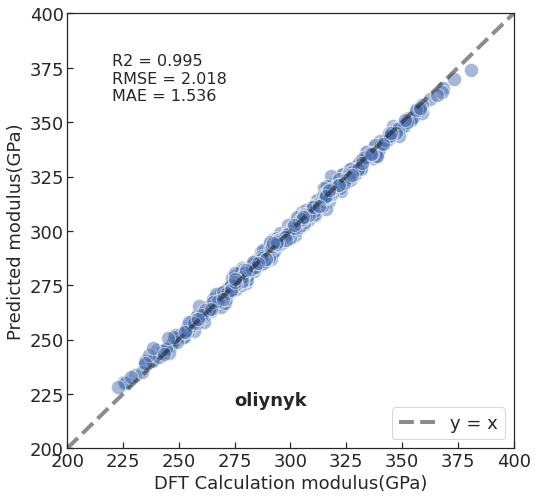

In [37]:
####  elem_prop='oliynyk'
calc_pred_curve(X_oli, y)

## Jarvis Feature

In [39]:
feats = Featurize(train_file, scale=True, save=True)

Processing Input Data: 100%|███████████████████████████████████████████████████████| 495/495 [00:00<00:00, 34268.32it/s]


	Featurizing Compositions...


Assigning Features...: 100%|███████████████████████████████████████████████████████| 495/495 [00:00<00:00, 25454.62it/s]


	Creating Pandas Objects...


In [40]:
X_jarv = pd.DataFrame(feats.X, columns=feats.columns)
X_jarv.to_csv('featurized_data/X_jarv.csv', index=False)

In [41]:
#### 定义x,y
y = df_bulk["target"].values

#### rf_training
rf_cross_validation(X_jarv,y)

#### rf_test
rf_test(X_jarv,y,df_bulk)  ### 需要含有formula的df

training R2 = 0.996
training RMSE = 1.847
training MAE = 1.328
Cross-validation results:
Folds: 10, mean R2: 0.971
Folds: 10, mean MAE: 3.724
Folds: 10, mean RMSE: 5.107
training R2 = 0.996
training RMSE = 2.021
training MAE = 1.503
test R2 = 0.97
test RMSE = 5.352
test MAE = 3.924


In [39]:
X_jarv

,avg_C-0,avg_C-1,avg_C-10,avg_C-11,avg_C-12,avg_C-13,avg_C-14,avg_C-15,avg_C-16,avg_C-17,...,range_voro_coord_subs_atom_rad,range_voro_coord_subs_bp,range_voro_coord_subs_elec_aff,range_voro_coord_subs_first_ion_en,range_voro_coord_subs_hfus,range_voro_coord_subs_mol_vol,range_voro_coord_subs_mp,range_voro_coord_subs_polzbl,range_voro_coord_subs_therm_cond,formula
0,0.038958,-0.004492,0.0,0.0,-0.000308,-0.000308,0.039782,0.0,0.0,0.0,...,0.055278,0.011242,0.059992,0.057961,0.056667,0.052913,0.008695,-0.016684,-0.004123,Hf1 Cr3 C4
1,0.043899,0.014247,0.0,0.0,0.015632,0.015632,0.044531,0.0,0.0,0.0,...,0.000586,0.009035,-0.001890,0.010598,0.003779,0.028010,-0.001338,-0.030469,-0.050847,Cr3 Mo1 C4
2,0.057018,0.000523,0.0,0.0,0.006245,0.006245,0.057952,0.0,0.0,0.0,...,0.020578,0.014679,0.024518,0.017827,0.019374,0.049778,-0.026723,-0.046441,-0.015224,Hf1 Cr2 Mo1 C4
3,0.026827,-0.009916,0.0,0.0,-0.002925,-0.002925,0.025352,0.0,0.0,0.0,...,0.020684,0.019959,0.023295,0.021797,0.020418,0.046253,-0.026728,0.016605,-0.030634,NaN
4,0.006751,0.029287,0.0,0.0,0.030115,0.030115,0.003305,0.0,0.0,0.0,...,0.000820,0.065965,0.004418,0.008312,0.005456,0.043727,0.001611,-0.037872,-0.045220,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,-0.022104,-0.040184,0.0,0.0,-0.031270,-0.031270,-0.022995,0.0,0.0,0.0,...,0.007574,0.003919,0.006481,-0.002428,0.003914,0.031715,-0.024077,0.022192,-0.023187,Ti2 Nb1 Cr1 C4
491,-0.032325,-0.052845,0.0,0.0,-0.054423,-0.054423,-0.027626,0.0,0.0,0.0,...,0.006192,-0.035274,0.005600,-0.008295,0.000735,-0.034971,-0.003916,0.009805,0.034477,Nb1 V2 Cr1 C4
492,-0.021811,-0.031109,0.0,0.0,-0.034034,-0.034034,-0.017419,0.0,0.0,0.0,...,0.005761,0.001853,0.004532,-0.009637,-0.000011,-0.031155,0.040751,0.022239,0.068249,Nb1 Cr1 W2 C4
493,-0.025280,-0.053488,0.0,0.0,-0.054185,-0.054185,-0.020767,0.0,0.0,0.0,...,0.005837,-0.001210,0.005277,-0.005792,0.001522,0.030870,-0.000111,0.017701,-0.006943,Zr2 Nb1 Cr1 C4


In [42]:
X_jarv.drop('formula', axis=1, inplace=True)

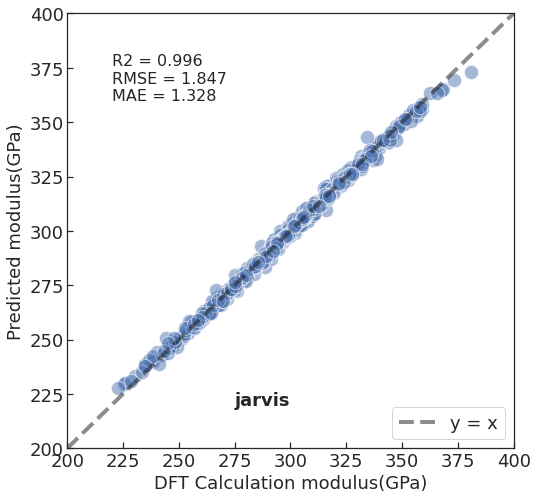

In [43]:
####  elem_prop='Jarvis'
#X_jarv.drop('formula', axis=1, inplace=True)
calc_pred_curve(X_jarv, y)

In [44]:
#Try a random forest model
rf_jarvs = RandomForestRegressor(n_estimators=100, random_state=1)
rf_jarvs.fit(X_jarv, y)

RandomForestRegressor(random_state=1)

In [45]:
df_125 = pd.read_csv("/home/zhaoxi/Data/df_bulk_125.csv",index_col = 0)
df_125_pred = df_125.drop("bulk_modulus",axis = 1)
df_125.to_csv("/home/zhaoxi/Software/CBFV/BestPractices-master/notebooks/CBFV/data/modulus/bulk/125_train.csv",index = False)

In [46]:
df_125["formula"]

0       Hf1 Zr2 Ta4 V1 C8
1      Hf1 Zr2 Ta4 Nb1 C8
2      Hf1 Zr2 Ta4 Ti1 C8
3      Hf1 Zr2 Ta4 Mo1 C8
4       Hf1 Zr2 Ta4 W1 C8
              ...        
118     Ti2 Nb4 Mo1 W1 C8
119    Ti2 Nb4 Cr1 Mo1 C8
120     Ti2 Nb4 Cr1 W1 C8
121     Nb4 Cr1 Mo2 W1 C8
122     Ti4 Cr1 Mo2 W1 C8
Name: formula, Length: 123, dtype: object

In [47]:
## predict

train_file = 'data/modulus/bulk/125_train.csv'
feats = Featurize(train_file, scale=True, save=True)
X_jarv_test = pd.DataFrame(feats.X, columns=feats.columns)

Processing Input Data: 100%|███████████████████████████████████████████████████████| 123/123 [00:00<00:00, 19092.54it/s]


	Featurizing Compositions...


Assigning Features...: 100%|████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 8233.58it/s]


	Creating Pandas Objects...


In [48]:
df_125["pred_modulus"] = rf_jarvs.predict(X_jarv_test)

In [49]:
df_125.describe()

,bulk_modulus,pred_modulus
count,123.000000,123.000000
mean,287.831382,301.062164
std,28.127178,35.125464
min,235.395000,240.526510
25%,261.373500,266.534235
50%,292.695000,305.601770
75%,310.510500,330.530705
max,335.256000,355.453240


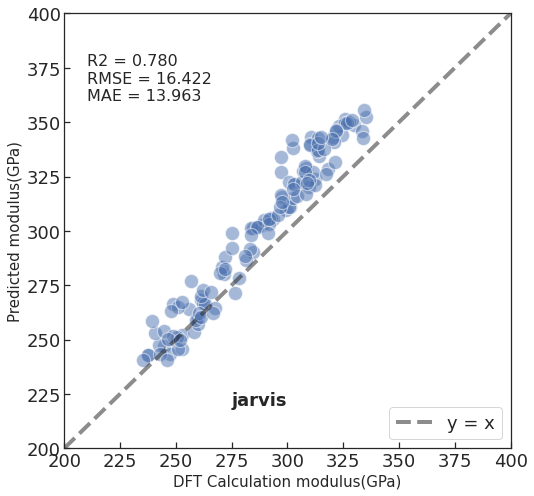

In [51]:
    y_pred = df_125["pred_modulus"].to_numpy()
    y_test = df_125["bulk_modulus"].to_numpy()

    xy_mse = np.sum((y_pred-y_test)**2);
    xy_mean = np.mean(y_pred);
    xx_mean = np.sum((y_pred - xy_mean)**2);
    R2 = 1 - xy_mse/xx_mean
    #R = np.sqrt(1 - xy_mse/xx_mean)
    MAE = np.mean(np.abs(y_pred - y_test))
    RMSE = np.sqrt(np.mean((y_pred - y_test)**2))
    str_R2 = 'R2 = %.3f \nRMSE = %.3f \nMAE = %.3f '%(R2, RMSE, MAE)     
    
    f,ax= plt.subplots(figsize = (8, 8))

    ##plt.title('%s'%file[:-4])
    #plt.title('The demo of scatter map')

    ####   set the colorbar font size
    #### https://stackoverflow.com/questions/34706845/change-xticklabels-fontsize-of-seaborn-heatmap 

    ####   set the x y labels font size 
    ####  https://www.cnblogs.com/lemonbit/p/7419851.html
    ax.tick_params(labelsize = 18) #
    formatXy = 'y = x'
    #  # ax.set_ylabel('the Number of Models',fontsize=15, color='r')
    ## cmap='BrBG'  'RdBu'
    scatter = sns.scatterplot(data=df_125, x= "bulk_modulus", y="pred_modulus", s=200,marker='o',alpha = 0.5, color = 'b')

    ax.plot((0, 1), (0, 1), transform=ax.transAxes, linewidth=4, ls='--',c='k',alpha=0.5, label = formatXy)

    ax.legend(loc = 'lower right', fontsize = 18)
 
    ax.text(210,360,str_R2,fontsize = 16)      
    ax.text(275,220,'jarvis',fontsize = 18,fontweight='bold')
    ax.set_ylim(200,400)
    ax.set_xlim(200,400)
    plt.tick_params(left='on',bottom='on',direction='in')
    plt.xlabel( 'DFT Calculation modulus(GPa)',fontsize=15)
    plt.ylabel( 'Predicted modulus(GPa)',fontsize=15)
    f.savefig('/mnt/e/ZHAO/Data/ELASTIC_HEC/Figure/cbfv_bulk_jarvis_125_4.9.png', dpi = 600, bbox_inches = 'tight')
    plt.show()

## Magpie

In [58]:
feats = Featurize(train_file, scale=True, save=True)

X_Magpie = pd.DataFrame(feats.X, columns=feats.columns)
X_Magpie.to_csv('featurized_data/X_Magpie.csv', index=False)

Processing Input Data: 100%|███████████████████████████████████████████████████████| 495/495 [00:00<00:00, 31467.77it/s]


	Featurizing Compositions...


Assigning Features...: 100%|███████████████████████████████████████████████████████| 495/495 [00:00<00:00, 22883.57it/s]

	Creating Pandas Objects...


In [59]:
#### 定义x,y
y = df_bulk["target"].values

#### rf_training
rf_cross_validation(X_Magpie,y)

#### rf_test
rf_test(X_Magpie,y,df_bulk)  ### 需要含有formula的df

training R2 = 0.994
training RMSE = 2.294
training MAE = 1.745
Cross-validation results:
Folds: 10, mean R2: 0.957
Folds: 10, mean MAE: 4.844
Folds: 10, mean RMSE: 6.322
training R2 = 0.993
training RMSE = 2.517
training MAE = 1.936
test R2 = 0.95
test RMSE = 6.848
test MAE = 5.360


In [61]:
X_Magpie = X_Magpie.drop("formula",axis =1)

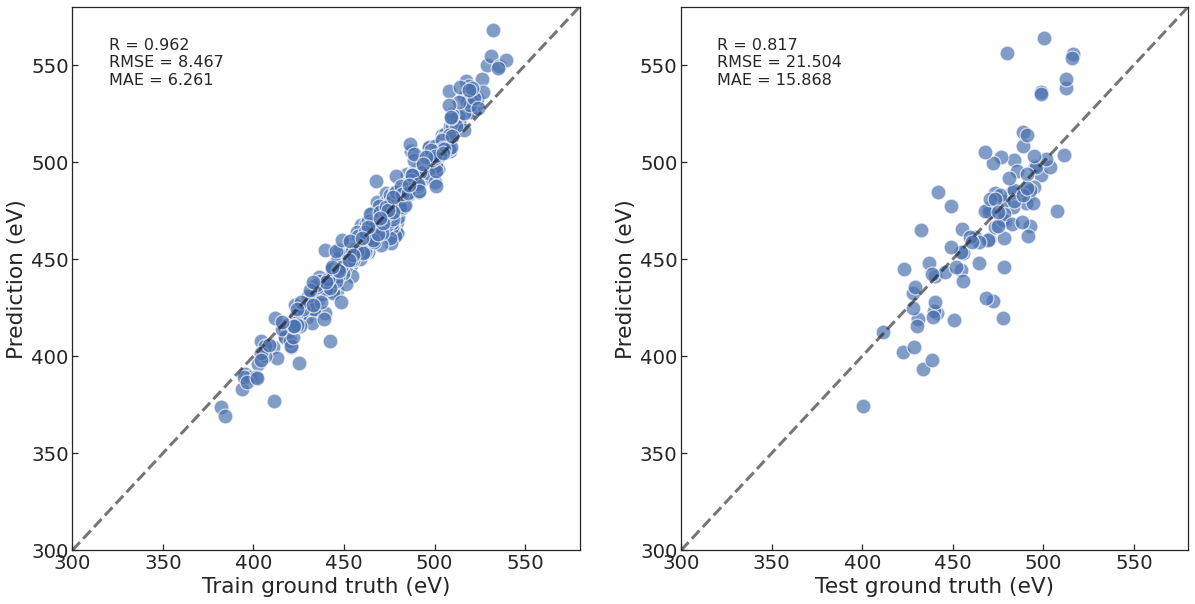

In [105]:
estimator = RandomForestRegressor(n_estimators=100, random_state=1)

df_modulus_ovp_Magpie = calc_obs_vs_pred(X_Magpie, y, estimator=estimator)

plot_obs_vs_pred(df_modulus_ovp_Magpie)

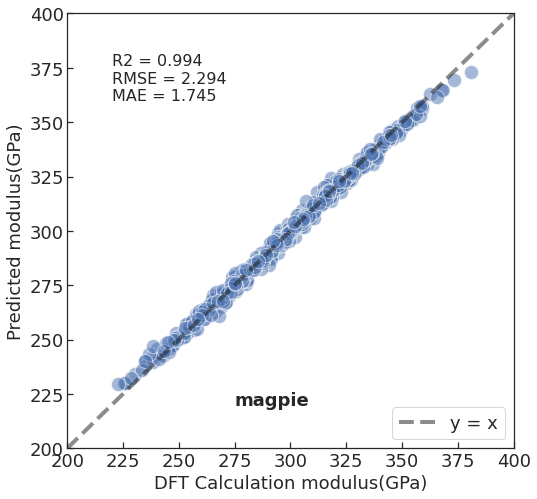

In [62]:
####  elem_prop='Magpie'
calc_pred_curve(X_Magpie, y)

## Mat2vec

In [65]:
feats = Featurize(train_file, scale=True, save=True)

X_Mat2vec = pd.DataFrame(feats.X, columns=feats.columns)

X_Mat2vec.to_csv('featurized_data/X_Mat2vec.csv', index=False)

Processing Input Data: 100%|███████████████████████████████████████████████████████| 495/495 [00:00<00:00, 30196.79it/s]


	Featurizing Compositions...


Assigning Features...: 100%|███████████████████████████████████████████████████████| 495/495 [00:00<00:00, 26617.36it/s]


	Creating Pandas Objects...


In [66]:
#### 定义x,y
y = df_bulk["target"].values

#### rf_training
rf_cross_validation(X_Mat2vec,y)

#### rf_test
rf_test(X_Mat2vec,y,df_bulk)  ### 需要含有formula的df

training R2 = 0.996
training RMSE = 1.916
training MAE = 1.488
Cross-validation results:
Folds: 10, mean R2: 0.973
Folds: 10, mean MAE: 3.902
Folds: 10, mean RMSE: 5.004
training R2 = 0.996
training RMSE = 1.971
training MAE = 1.524
test R2 = 0.964
test RMSE = 5.855
test MAE = 4.162


In [67]:
X_Mat2vec = X_Mat2vec.drop("formula",axis =1)

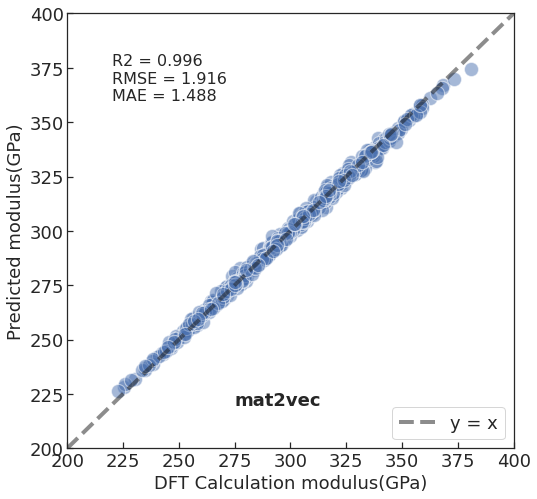

In [68]:
####  elem_prop='Mat2vec'
calc_pred_curve(X_Mat2vec, y)

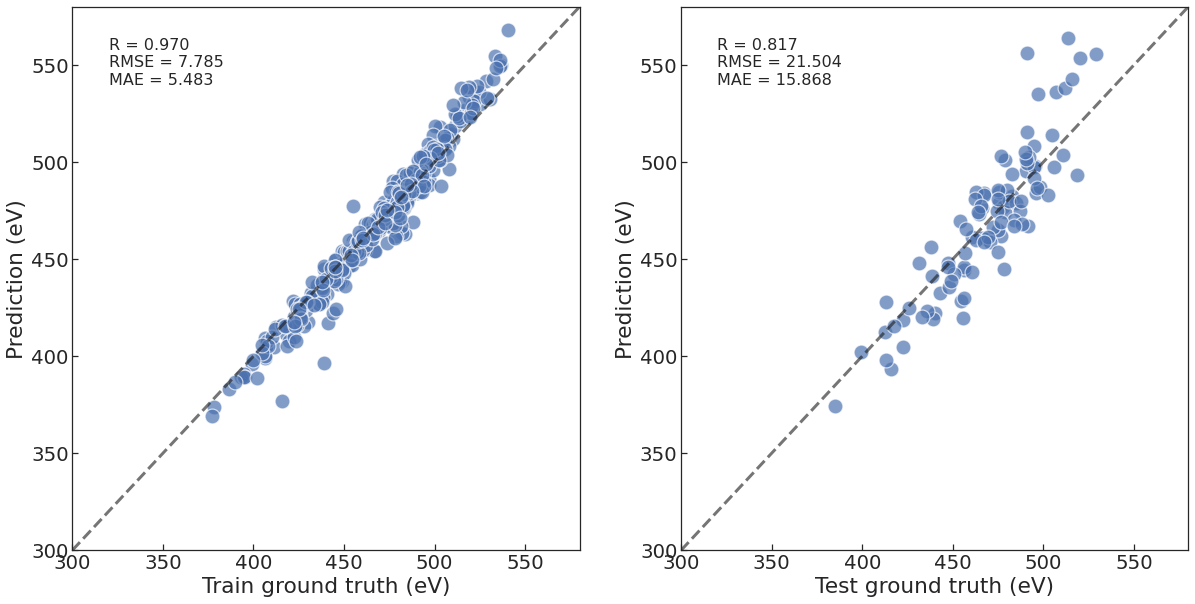

In [121]:
estimator = RandomForestRegressor(n_estimators=100, random_state=1)

df_modulus_ovp_Mat2vec = calc_obs_vs_pred(X_Mat2vec, y, estimator=estimator)

plot_obs_vs_pred(df_modulus_ovp_Mat2vec)

## One-hot

In [71]:
feats = Featurize(train_file, scale=True, save=True)

X_onehot = pd.DataFrame(feats.X, columns=feats.columns)

X_onehot.to_csv('featurized_data/X_onehot.csv', index=False)

Processing Input Data: 100%|███████████████████████████████████████████████████████| 495/495 [00:00<00:00, 29425.16it/s]


	Featurizing Compositions...


Assigning Features...: 100%|███████████████████████████████████████████████████████| 495/495 [00:00<00:00, 28694.36it/s]

	Creating Pandas Objects...


In [72]:
#### 定义x,y
y = df_bulk["target"].values

#### rf_training
rf_cross_validation(X_onehot,y)

#### rf_test
rf_test(X_onehot,y,df_bulk)  ### 需要含有formula的df

training R2 = 0.994
training RMSE = 2.442
training MAE = 1.790
Cross-validation results:
Folds: 10, mean R2: 0.949
Folds: 10, mean MAE: 4.975
Folds: 10, mean RMSE: 6.738
training R2 = 0.992
training RMSE = 2.795
training MAE = 2.097
test R2 = 0.936
test RMSE = 7.759
test MAE = 5.801


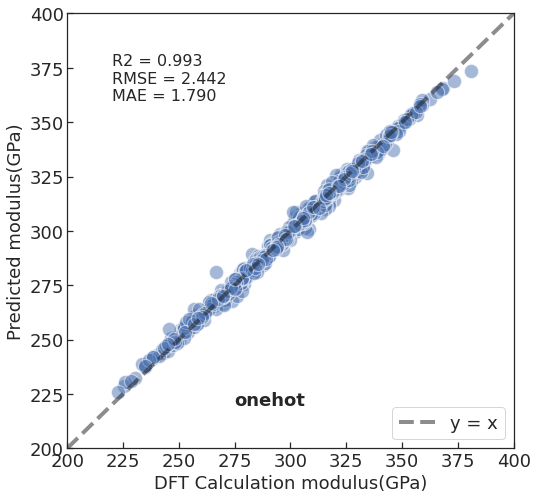

In [81]:
####  elem_prop='onehot'
#X_onehot = X_onehot.drop("formula",axis =1)
calc_pred_curve(X_onehot, y)

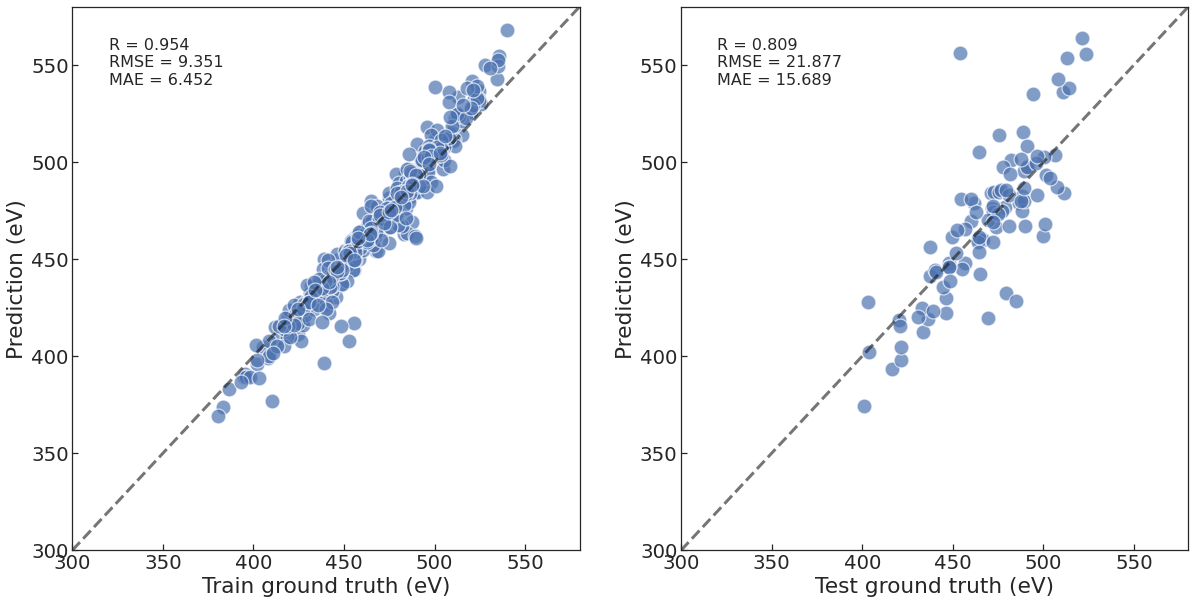

In [129]:
X_onehot = X_onehot.drop("formula",axis =1)
estimator = RandomForestRegressor(n_estimators=100, random_state=1)

df_modulus_ovp_onehot = calc_obs_vs_pred(X_onehot, y, estimator=estimator)

plot_obs_vs_pred(df_modulus_ovp_onehot)

## random_200

In [76]:
feats = Featurize(train_file, scale=True, save=True)

X_random = pd.DataFrame(feats.X, columns=feats.columns)

X_random.to_csv('featurized_data/X_random.csv', index=False)

Processing Input Data: 100%|███████████████████████████████████████████████████████| 495/495 [00:00<00:00, 34787.38it/s]


	Featurizing Compositions...


Assigning Features...: 100%|███████████████████████████████████████████████████████| 495/495 [00:00<00:00, 26830.97it/s]


	Creating Pandas Objects...


In [77]:
#### 定义x,y
y = df_bulk["target"].values

#### rf_training
rf_cross_validation(X_random,y)

#### rf_test
rf_test(X_random,y,df_bulk)  ### 需要含有formula的df

training R2 = 0.996
training RMSE = 1.971
training MAE = 1.485
Cross-validation results:
Folds: 10, mean R2: 0.968
Folds: 10, mean MAE: 4.148
Folds: 10, mean RMSE: 5.416
training R2 = 0.995
training RMSE = 2.207
training MAE = 1.702
test R2 = 0.962
test RMSE = 6.022
test MAE = 4.492


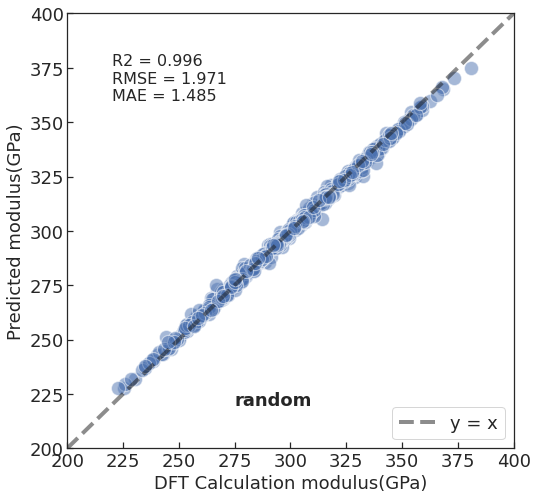

In [78]:
####  elem_prop='random_200'
X_random.drop('formula', axis=1, inplace=True)
calc_pred_curve(X_random, y)

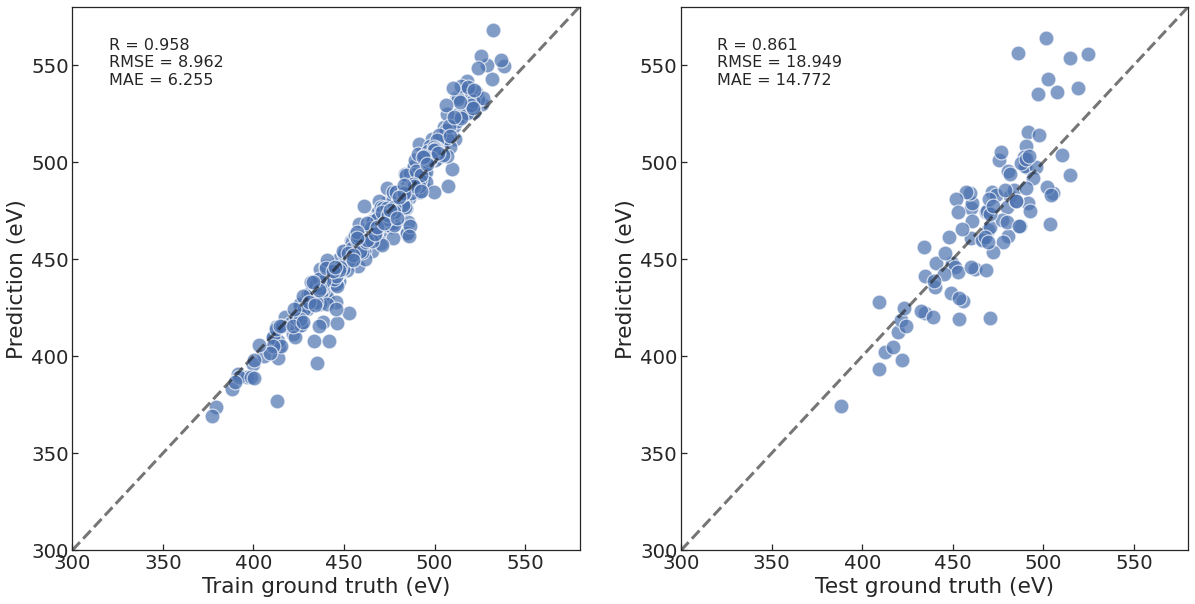

In [136]:
X_random = X_random.drop("formula",axis =1)
estimator = RandomForestRegressor(n_estimators=100, random_state=1)

df_modulus_ovp_random = calc_obs_vs_pred(X_random, y, estimator=estimator)

plot_obs_vs_pred(df_modulus_ovp_random)

In [103]:
##########学习曲线

def calc_learning_curve_1(X1, X2, X3, X4, X5, X6, y, estimator):
    
    cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
    
    estimator = RandomForestRegressor(n_estimators=100, random_state=1)
    train_sizes, train_scores, test_scores = learning_curve(
    estimator, X1, y,scoring='neg_mean_absolute_error', cv=cv, 
    train_sizes=[0.1, 0.25, 0.5, 0.75, 1])
    test_scores_mean1 = np.mean(test_scores, axis=1)* -1
    
    train_sizes, train_scores, test_scores = learning_curve(
    estimator, X2, y, scoring='neg_mean_absolute_error', cv=cv, 
    train_sizes=[0.1, 0.25, 0.5, 0.75, 1])
    test_scores_mean2 = np.mean(test_scores, axis=1)* -1

    test_sizes, train_scores, test_scores = learning_curve(
    estimator, X3, y, scoring='neg_mean_absolute_error', cv=cv, 
    train_sizes=[0.1, 0.25, 0.5, 0.75, 1])
    test_scores_mean3 = np.mean(test_scores, axis=1)* -1
    
    test_sizes, train_scores, test_scores = learning_curve(
    estimator, X4, y, scoring='neg_mean_absolute_error', cv=cv, 
    train_sizes=[0.1, 0.25, 0.5, 0.75, 1])
    test_scores_mean4 = np.mean(test_scores, axis=1)* -1
    
    test_sizes, train_scores, test_scores = learning_curve(
    estimator, X5, y, scoring='neg_mean_absolute_error', cv=cv, 
    train_sizes=[0.1, 0.25, 0.5, 0.75, 1])
    test_scores_mean5 = np.mean(test_scores, axis=1)* -1
    
    test_sizes, train_scores, test_scores = learning_curve(
    estimator, X6, y, scoring='neg_mean_absolute_error', cv=cv, 
    train_sizes=[0.1, 0.25, 0.5, 0.75, 1])
    test_scores_mean6 = np.mean(test_scores, axis=1)* -1
    
    # plot_learning_curve
    plt.figure(figsize=(10, 10))
#    plt.grid(linestyle='-', linewidth=1, alpha=0.8)  # Adding grid lines for better visualization
    plt.plot(train_sizes, test_scores_mean1, 'o-',markersize=15,linewidth=4, color="r", label="Jarvis") ### train_scores每组数据进行训练后的算法训练得分。
    plt.plot(train_sizes, test_scores_mean2, 'X-',markersize=15,linewidth=4, color="g", label="Magpie")
    plt.plot(train_sizes, test_scores_mean3, 'D-',markersize=15,linewidth=4, color="orange", label="Mat2vec")
    plt.plot(train_sizes, test_scores_mean4, 'P-',markersize=15,linewidth=4, color="royalblue", label="Onehot") ### train_scores每组数据进行训练后的算法训练得分。
    plt.plot(train_sizes, test_scores_mean5, 's-',markersize=15,linewidth=4, color="hotpink", label="Oliynyk")
    plt.plot(train_sizes, test_scores_mean6, '*-',markersize=15,linewidth=4, color="slateblue", label="random")
    

    plt.legend(loc ="best", fontsize = 18)
    plt.tick_params(labelsize = 18) 
    plt.xlabel("samples",fontsize = 20)
    plt.ylabel("Mean Absolute Error(GPa)",fontsize = 20)
    plt.tick_params(left='on',bottom='on',direction='in')
#    plt.title("Learning Curves",fontsize = 14)
    
    plt.savefig('/mnt/e/ZHAO/Data/ELASTIC_HEC/Figure/MAE_cbfv_4.9.png', dpi = 600, bbox_inches = 'tight')
    

In [239]:
plt.savefig('/mnt/e/ZHAO/Data/ELASTIC_HEC/Figure/MAE_cbfv.png', dpi = 600, bbox_inches = 'tight')

<Figure size 432x288 with 0 Axes>

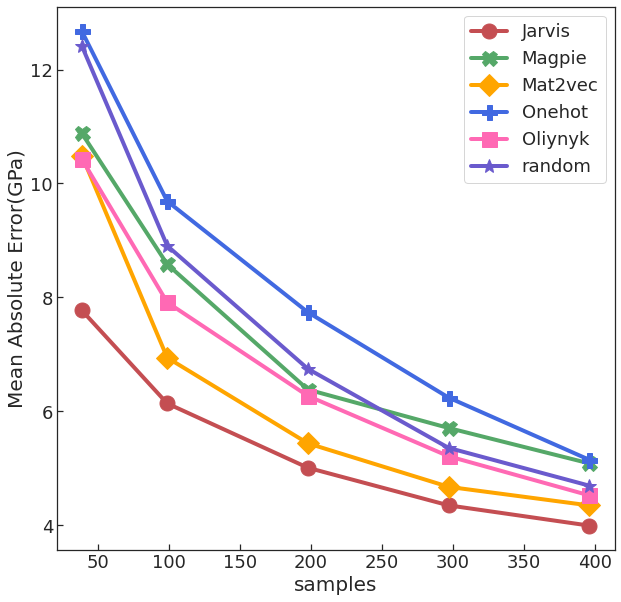

In [104]:
estimator = RandomForestRegressor(n_estimators=100, random_state=1)
df_x6_lc = calc_learning_curve_1(X_jarv, X_Magpie, X_Mat2vec,X_onehot,X_oli,X_random, y, estimator)

In [109]:
##########学习曲线

def calc_learning_curve_1(X1, X2, X3, X4, X5, X6, y, estimator):
    
    cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
    
    estimator = RandomForestRegressor(n_estimators=100, random_state=1)
    train_sizes, train_scores, test_scores = learning_curve(
    estimator, X1, y,scoring='r2', cv=cv, 
    train_sizes=[0.1, 0.25, 0.5, 0.75, 1])
    test_scores_mean1 = np.mean(test_scores, axis=1)
    
    train_sizes, train_scores, test_scores = learning_curve(
    estimator, X2, y, scoring='r2', cv=cv, 
    train_sizes=[0.1, 0.25, 0.5, 0.75, 1])
    test_scores_mean2 = np.mean(test_scores, axis=1)

    test_sizes, train_scores, test_scores = learning_curve(
    estimator, X3, y, scoring='r2', cv=cv, 
    train_sizes=[0.1, 0.25, 0.5, 0.75, 1])
    test_scores_mean3 = np.mean(test_scores, axis=1)
    
    test_sizes, train_scores, test_scores = learning_curve(
    estimator, X4, y, scoring='r2', cv=cv, 
    train_sizes=[0.1, 0.25, 0.5, 0.75, 1])
    test_scores_mean4 = np.mean(test_scores, axis=1)
    
    test_sizes, train_scores, test_scores = learning_curve(
    estimator, X5, y, scoring='r2', cv=cv, 
    train_sizes=[0.1, 0.25, 0.5, 0.75, 1])
    test_scores_mean5 = np.mean(test_scores, axis=1)
    
    test_sizes, train_scores, test_scores = learning_curve(
    estimator, X6, y, scoring='r2', cv=cv, 
    train_sizes=[0.1, 0.25, 0.5, 0.75, 1])
    test_scores_mean6 = np.mean(test_scores, axis=1)
    
    # plot_learning_curve
    plt.figure(figsize=(10, 10))
#    plt.grid(linestyle='-', linewidth=1, alpha=0.8)  # Adding grid lines for better visualization
    plt.plot(train_sizes, test_scores_mean1, 'o-',markersize=15,linewidth=4, color="r", label="Jarvis") ### train_scores每组数据进行训练后的算法训练得分。
    plt.plot(train_sizes, test_scores_mean2, 'X-',markersize=15,linewidth=4, color="g", label="Magpie")
    plt.plot(train_sizes, test_scores_mean3, 'D-',markersize=15,linewidth=4, color="orange", label="Mat2vec")
    plt.plot(train_sizes, test_scores_mean4, 'P-',markersize=15,linewidth=4, color="royalblue", label="Onehot") ### train_scores每组数据进行训练后的算法训练得分。
    plt.plot(train_sizes, test_scores_mean5, 's-',markersize=15,linewidth=4, color="hotpink", label="Oliynyk")
    plt.plot(train_sizes, test_scores_mean6, '*-',markersize=15,linewidth=4, color="slateblue", label="random")
    

    plt.legend(loc ="best", fontsize = 18)
    plt.tick_params(labelsize = 18) 
    plt.xlabel("samples",fontsize = 20)
    plt.ylabel("r2 scores",fontsize = 20)
    plt.tick_params(left='on',bottom='on',direction='in')
#    plt.title("Learning Curves",fontsize = 14)
    
    plt.savefig('/mnt/e/ZHAO/Data/ELASTIC_HEC/Figure/r2_cbfv.png', dpi = 600, bbox_inches = 'tight')
    

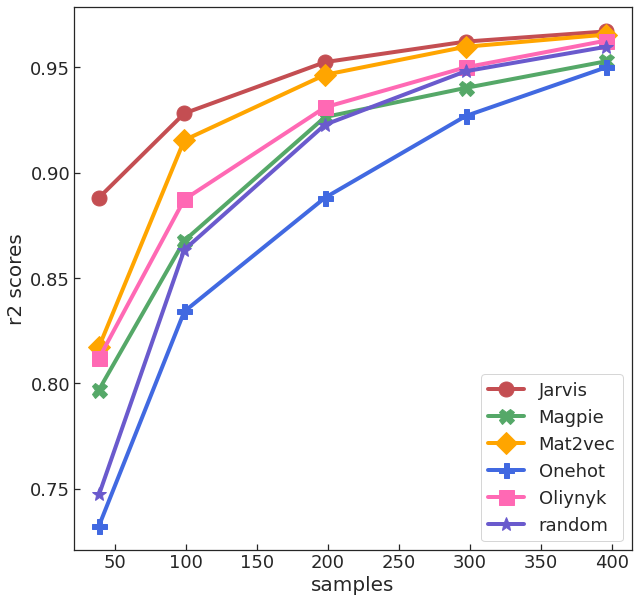

In [110]:
estimator = RandomForestRegressor(n_estimators=100, random_state=1)
df_x6_lc_r2 = calc_learning_curve_1(X_jarv, X_Magpie, X_Mat2vec,X_onehot,X_oli,X_random, y, estimator)

In [115]:
##########学习曲线

def calc_learning_curve_1(X1, X2, X3, X4, X5, X6, y, estimator):
    
    cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
    
    estimator = RandomForestRegressor(n_estimators=100, random_state=1)
    
    train_sizes, train_scores, test_scores = learning_curve(
    estimator, X1, y,scoring='neg_mean_squared_error', cv=cv, 
    train_sizes=[0.1, 0.25, 0.5, 0.75, 1])
# Calculate the mean of the test scores for each number of training samples, 
# take the square root of the absolute value (since scores are negative),
# this gives us the RMSE for each training size.
    test_scores_mean1 = np.mean(test_scores, axis=1)
    test_scores_mean1 = np.sqrt(abs(test_scores_mean1))

    train_sizes, train_scores, test_scores = learning_curve(
    estimator, X2, y,scoring='neg_mean_squared_error', cv=cv, 
    train_sizes=[0.1, 0.25, 0.5, 0.75, 1])
# Calculate the mean of the test scores for each number of training samples, 
# take the square root of the absolute value (since scores are negative),
# this gives us the RMSE for each training size.
    test_scores_mean2 = np.mean(test_scores, axis=1)
    test_scores_mean2 = np.sqrt(abs(test_scores_mean2))

    train_sizes, train_scores, test_scores = learning_curve(
    estimator, X3, y,scoring='neg_mean_squared_error', cv=cv, 
    train_sizes=[0.1, 0.25, 0.5, 0.75, 1])
# Calculate the mean of the test scores for each number of training samples, 
# take the square root of the absolute value (since scores are negative),
# this gives us the RMSE for each training size.
    test_scores_mean3 = np.mean(test_scores, axis=1)
    test_scores_mean3 = np.sqrt(abs(test_scores_mean3))

    train_sizes, train_scores, test_scores = learning_curve(
    estimator, X4, y,scoring='neg_mean_squared_error', cv=cv, 
    train_sizes=[0.1, 0.25, 0.5, 0.75, 1])
# Calculate the mean of the test scores for each number of training samples, 
# take the square root of the absolute value (since scores are negative),
# this gives us the RMSE for each training size.
    test_scores_mean4 = np.mean(test_scores, axis=1)
    test_scores_mean4 = np.sqrt(abs(test_scores_mean4))
    
    train_sizes, train_scores, test_scores = learning_curve(
    estimator, X5, y,scoring='neg_mean_squared_error', cv=cv, 
    train_sizes=[0.1, 0.25, 0.5, 0.75, 1])
# Calculate the mean of the test scores for each number of training samples, 
# take the square root of the absolute value (since scores are negative),
# this gives us the RMSE for each training size.
    test_scores_mean5 = np.mean(test_scores, axis=1)
    test_scores_mean5 = np.sqrt(abs(test_scores_mean5))
    
    train_sizes, train_scores, test_scores = learning_curve(
    estimator, X6, y,scoring='neg_mean_squared_error', cv=cv, 
    train_sizes=[0.1, 0.25, 0.5, 0.75, 1])
# Calculate the mean of the test scores for each number of training samples, 
# take the square root of the absolute value (since scores are negative),
# this gives us the RMSE for each training size.
    test_scores_mean6 = np.mean(test_scores, axis=1)
    test_scores_mean6 = np.sqrt(abs(test_scores_mean6))
    
    
    # plot_learning_curve
    plt.figure(figsize=(10, 10))
#    plt.grid(linestyle='-',linewidth=1,alpha=0.8)   ## 加网格线
    plt.plot(train_sizes, test_scores_mean1, 'o-',markersize=15,linewidth=4, color="r", label="Jarvis") ### train_scores每组数据进行训练后的算法训练得分。
    plt.plot(train_sizes, test_scores_mean2, 'X-',markersize=15,linewidth=4, color="g", label="Magpie")
    plt.plot(train_sizes, test_scores_mean3, 'D-',markersize=15,linewidth=4, color="orange", label="Mat2vec")
    plt.plot(train_sizes, test_scores_mean4, 'P-',markersize=15,linewidth=4, color="royalblue", label="Onehot") ### train_scores每组数据进行训练后的算法训练得分。
    plt.plot(train_sizes, test_scores_mean5, 's-',markersize=15,linewidth=4, color="hotpink", label="Oliynyk")
    plt.plot(train_sizes, test_scores_mean6, '*-',markersize=15,linewidth=4, color="slateblue", label="random")
    


    plt.legend(loc ="best", fontsize = 18)
    plt.tick_params(labelsize = 18) 
    plt.xlabel("samples",fontsize = 18)
    plt.ylabel("Root Mean Square Error(GPa)",fontsize = 18)
    plt.tick_params(left='on',bottom='on',direction='in')
#    plt.title("Learning Curves",fontsize = 14)
    
    plt.savefig('/mnt/e/ZHAO/Data/ELASTIC_HEC/Figure/rmse_cbvf_4.9.png', dpi = 600, bbox_inches = 'tight')
    

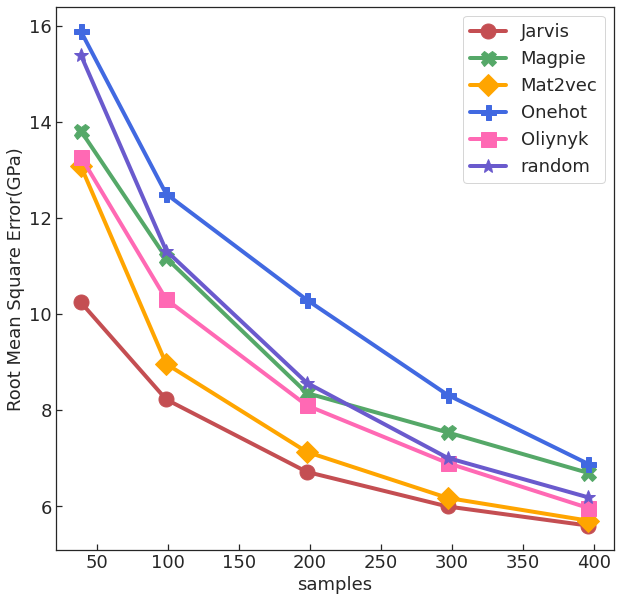

In [116]:
estimator = RandomForestRegressor(n_estimators=100, random_state=1)
df_x6_lc_rmse = calc_learning_curve_1(X_jarv, X_Magpie, X_Mat2vec,X_onehot,X_oli,X_random, y, estimator)

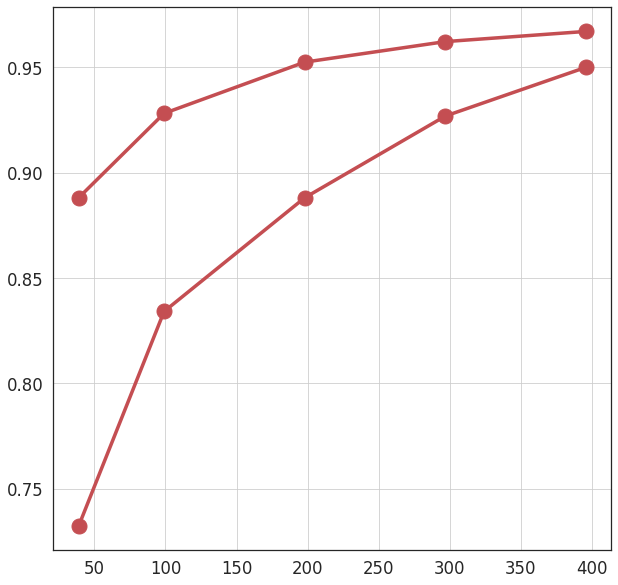

In [105]:
    cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
    
    estimator = RandomForestRegressor(n_estimators=100, random_state=1)
    train_sizes, train_scores, test_scores = learning_curve(
    estimator, X_onehot, y,scoring='r2', cv=cv, 
    train_sizes=[0.1, 0.25, 0.5, 0.75, 1])
    test_scores_mean1 = np.mean(test_scores, axis=1)
    
    train_sizes, train_scores, test_scores = learning_curve(
    estimator, X_jarv, y,scoring='r2', cv=cv, 
    train_sizes=[0.1, 0.25, 0.5, 0.75, 1])
    test_scores_mean2 = np.mean(test_scores, axis=1)
    
    plt.figure(figsize=(10, 10))
    plt.grid(linestyle='-',linewidth=1,alpha=0.8)   ## 加网格线
    plt.plot(train_sizes, test_scores_mean1, 'o-',markersize=15,linewidth=3.5, color="r", label="Onehot")
    plt.plot(train_sizes, test_scores_mean2, 'o-',markersize=15,linewidth=3.5, color="r", label="Onehot")

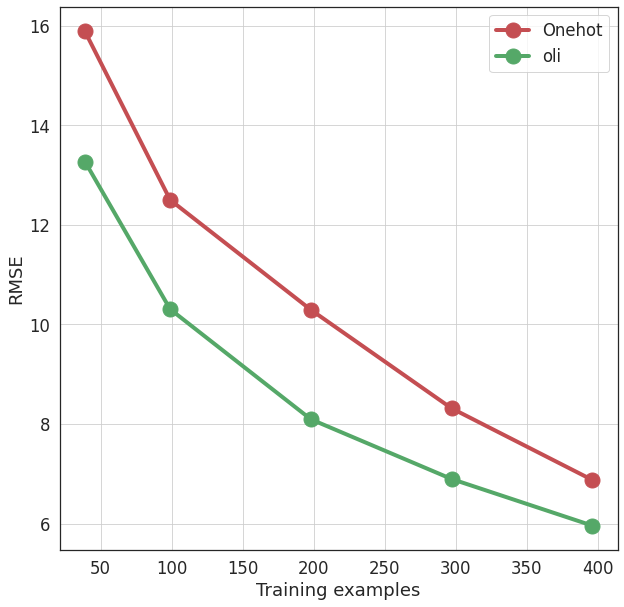

In [112]:


# Assuming X_onehot and y are defined

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = RandomForestRegressor(n_estimators=100, random_state=1)

train_sizes, train_scores, test_scores = learning_curve(
    estimator, X_onehot, y, scoring='neg_mean_squared_error', cv=cv,
    train_sizes=[0.1, 0.25, 0.5, 0.75, 1])

# Calculate the mean of the test scores for each number of training samples, 
# take the square root of the absolute value (since scores are negative),
# this gives us the RMSE for each training size.
test_scores_mean1 = np.mean(test_scores, axis=1)
test_scores_mean1 = np.sqrt(abs(test_scores_mean1))

#
train_sizes, train_scores, test_scores = learning_curve(
    estimator, X_oli, y, scoring='neg_mean_squared_error', cv=cv,
    train_sizes=[0.1, 0.25, 0.5, 0.75, 1])

test_scores_mean2 = np.mean(test_scores, axis=1)
test_scores_mean2 = np.sqrt(abs(test_scores_mean2))

plt.figure(figsize=(10, 10))
plt.grid(linestyle='-', linewidth=1, alpha=0.8)  # Adding grid lines for better visualization
plt.plot(train_sizes, test_scores_mean1, 'o-', markersize=15, linewidth=4, color="r", label="Onehot")
plt.plot(train_sizes, test_scores_mean2, 'o-', markersize=15, linewidth=4, color="g", label="oli")
plt.xlabel("Training examples")
plt.ylabel("RMSE")
#plt.title("RMSE vs. Training Size")
plt.legend(loc="best")
plt.show()


#### 